## Churn Prediction: Logistic Regression



### Data Preparation

In [2]:
import pandas as pd 
import numpy as np

import matplotlib.pyplot as plt

In [3]:
customers = pd.read_csv('input/customer.csv')

In [4]:
# customers = 'https://...'
# !wget $customers -0 input/customers.csv

In [5]:
customers.head().T

,0,1,2,3,4
customerID,7590-VHVEG,5575-GNVDE,3668-QPYBK,7795-CFOCW,9237-HQITU
gender,Female,Male,Male,Male,Female
SeniorCitizen,0,0,0,0,0
Partner,Yes,No,No,No,No
Dependents,No,No,No,No,No
tenure,1,34,2,45,2
PhoneService,No,Yes,Yes,No,Yes
MultipleLines,No phone service,No,No,No phone service,No
InternetService,DSL,DSL,DSL,DSL,Fiber optic
OnlineSecurity,No,Yes,Yes,Yes,No


In [6]:
customers.columns

Index(['customerID', 'gender', 'SeniorCitizen', 'Partner', 'Dependents',
       'tenure', 'PhoneService', 'MultipleLines', 'InternetService',
       'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport',
       'StreamingTV', 'StreamingMovies', 'Contract', 'PaperlessBilling',
       'PaymentMethod', 'MonthlyCharges', 'TotalCharges', 'Churn'],
      dtype='object')

In [7]:
customers.columns = customers.columns.str.lower()
categorical_columns = customers.dtypes[customers.dtypes == 'object'].index #index: gets the index labels (which are the column names) of this filtered Series
for c in categorical_columns:
    customers[c] = customers[c].str.lower().str.replace(' ', '_')

In [8]:
customers.head()

,customerid,gender,seniorcitizen,partner,dependents,tenure,phoneservice,multiplelines,internetservice,onlinesecurity,onlinebackup,deviceprotection,techsupport,streamingtv,streamingmovies,contract,paperlessbilling,paymentmethod,monthlycharges,totalcharges,churn
0,7590-vhveg,female,0,yes,no,1,no,no_phone_service,dsl,no,yes,no,no,no,no,month-to-month,yes,electronic_check,29.85,29.85,no
1,5575-gnvde,male,0,no,no,34,yes,no,dsl,yes,no,yes,no,no,no,one_year,no,mailed_check,56.95,1889.5,no
2,3668-qpybk,male,0,no,no,2,yes,no,dsl,yes,yes,no,no,no,no,month-to-month,yes,mailed_check,53.85,108.15,yes
3,7795-cfocw,male,0,no,no,45,no,no_phone_service,dsl,yes,no,yes,yes,no,no,one_year,no,bank_transfer_(automatic),42.30,1840.75,no
4,9237-hqitu,female,0,no,no,2,yes,no,fiber_optic,no,no,no,no,no,no,month-to-month,yes,electronic_check,70.70,151.65,yes


In [9]:
customers.dtypes

customerid           object
gender               object
seniorcitizen         int64
partner              object
dependents           object
tenure                int64
phoneservice         object
multiplelines        object
internetservice      object
onlinesecurity       object
onlinebackup         object
deviceprotection     object
techsupport          object
streamingtv          object
streamingmovies      object
contract             object
paperlessbilling     object
paymentmethod        object
monthlycharges      float64
totalcharges         object
churn                object
dtype: object

In [10]:
# "totalcharges" has an object data type while it should be a number. So I will change it to a numeric data file.
customers.totalcharges = pd.to_numeric(customers.totalcharges, errors = 'coerce')  # There are some empty cells that cannot be parsed, I will use coerce to ignore them.

In [11]:
customers[customers.totalcharges.isnull()][['customerid', 'totalcharges']]

,customerid,totalcharges
488,4472-lvygi,NaN
753,3115-czmzd,NaN
936,5709-lvoeq,NaN
1082,4367-nuyao,NaN
1340,1371-dwpaz,NaN
3331,7644-omvmy,NaN
3826,3213-vvolg,NaN
4380,2520-sgtta,NaN
5218,2923-arzlg,NaN
6670,4075-wkniu,NaN


In [12]:
# I will replace the empty cells with 0.
customers.totalcharges.fillna(0, inplace=True)

/tmp/ipykernel_2854/3893934657.py:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  customers.totalcharges.fillna(0, inplace=True)


In [13]:
# I'll have a look at the churn column.
customers.churn

0        no
1        no
2       yes
3        no
4       yes
       ... 
7038     no
7039     no
7040     no
7041    yes
7042     no
Name: churn, Length: 7043, dtype: object

In [14]:
# I will change yes/no to 1 and 0.
customers.churn = (customers.churn == 'yes').astype(int)


In [15]:
customers.churn

0       0
1       0
2       1
3       0
4       1
       ..
7038    0
7039    0
7040    0
7041    1
7042    0
Name: churn, Length: 7043, dtype: int64

### Setting Up the Validation Framework

In [16]:
# I will split the data into train, validation and test sets, using scikit-learn. Train: 60%, Validation: 20%, Test: 20%. First, I will split the data into train (full train: %80) and test sets (%20), then I will split the train set into train and validation sets.

from sklearn.model_selection import train_test_split

customers_full_train, customers_test = train_test_split(customers, test_size = 0.2, random_state = 1)
customers_train, customers_val = train_test_split(customers_full_train, test_size = 0.25, random_state = 1)  # 0.2 / 0.8 = 0.25 because the validation set should be 20% of the full data and 20% of full data set is 25% of the full train set.
len(customers_train), len(customers_val), len(customers_test)

(4225, 1409, 1409)

In [17]:
customers_train = customers_train.reset_index(drop=True) 
customers_val = customers_val.reset_index(drop=True)
customers_test = customers_test.reset_index(drop=True)

In [18]:
# Let's get the y variables
y_train = customers_train.churn.values
y_val = customers_val.churn.values
y_test = customers_test.churn.values

# "y_test = customers_test.churn" returns a pandas Series object.
# "y_test = customers_test.churn.values" returns a NumPy array.


In [19]:
del customers_train['churn']
del customers_val['churn']
del customers_test['churn']

### Exploratory Data Analysis

In [20]:
customers_full_train = customers_full_train.reset_index(drop=True)

In [21]:
customers_full_train.isnull().sum()
#There are no missing values in the data.

customerid          0
gender              0
seniorcitizen       0
partner             0
dependents          0
tenure              0
phoneservice        0
multiplelines       0
internetservice     0
onlinesecurity      0
onlinebackup        0
deviceprotection    0
techsupport         0
streamingtv         0
streamingmovies     0
contract            0
paperlessbilling    0
paymentmethod       0
monthlycharges      0
totalcharges        0
churn               0
dtype: int64

In [22]:
# Let's have a look at the target variable. 
customers_full_train.churn.value_counts(normalize = True) #normalize changes the counts to percentages.

churn
0    0.730032
1    0.269968
Name: proportion, dtype: float64

The churn rate is 0.27. 

In [23]:
global_churn_rate = customers_full_train.churn.mean()
round(global_churn_rate,2)

np.float64(0.27)

In [24]:
# Let's look at categorical and numerical variables.
customers_full_train.dtypes

customerid           object
gender               object
seniorcitizen         int64
partner              object
dependents           object
tenure                int64
phoneservice         object
multiplelines        object
internetservice      object
onlinesecurity       object
onlinebackup         object
deviceprotection     object
techsupport          object
streamingtv          object
streamingmovies      object
contract             object
paperlessbilling     object
paymentmethod        object
monthlycharges      float64
totalcharges        float64
churn                 int64
dtype: object

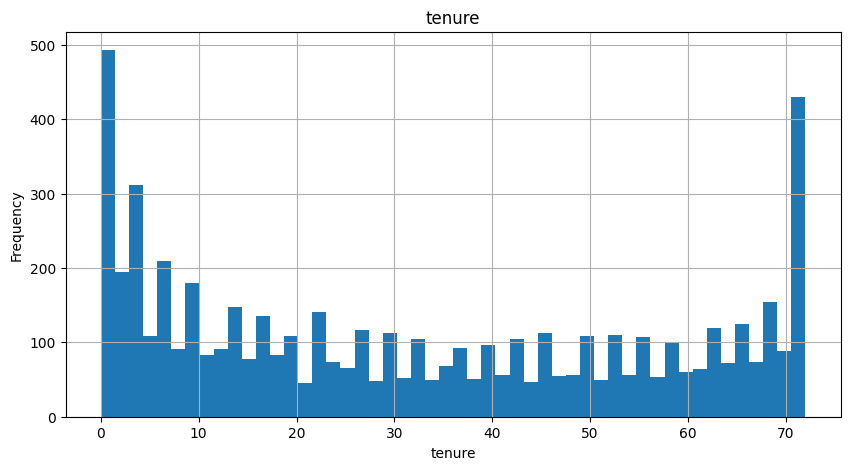

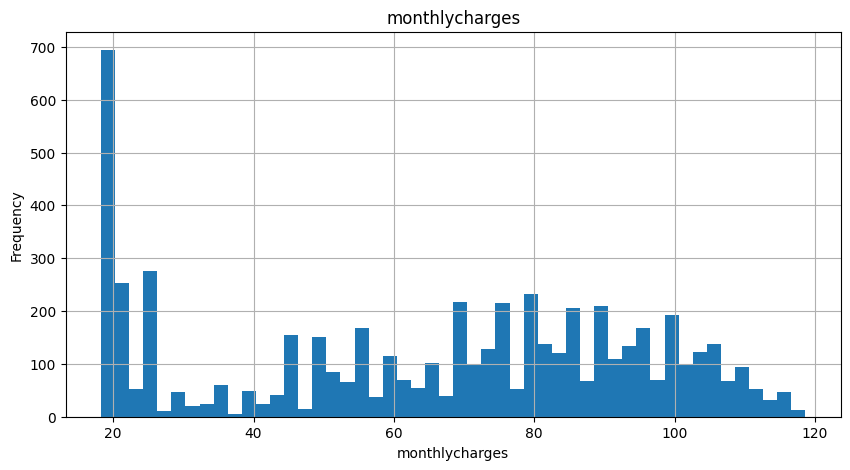

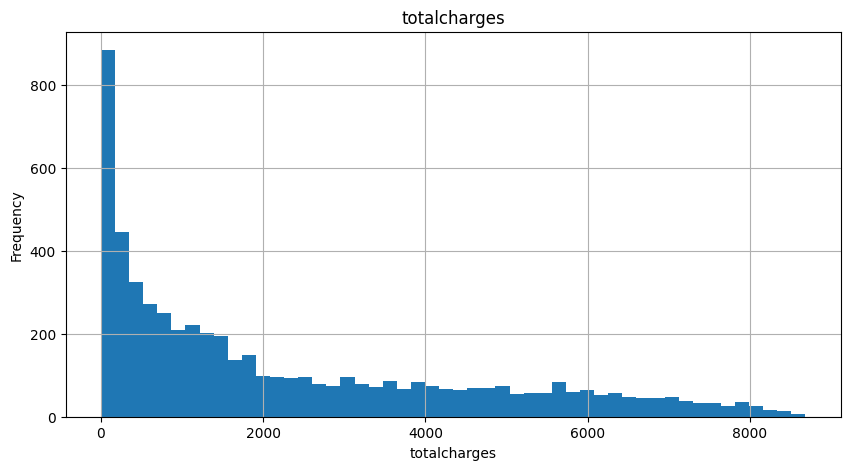

In [25]:
# I am interested in 3 numerical variables: "tenure", "monthlycharges" and "totalcharges". I will plot their distributions.
numerical = ['tenure', 'monthlycharges', 'totalcharges']
for c in numerical:
    plt.figure(figsize=(10, 5))
    customers_full_train[c].hist(bins=50)
    plt.title(c)
    plt.xlabel(c)
    plt.ylabel('Frequency')
    plt.show()

In [26]:
# Now I will look at the categorical variables.
categorical = customers_full_train.dtypes[customers_full_train.dtypes == 'object'].index
customers_full_train[categorical].nunique()

customerid          5634
gender                 2
partner                2
dependents             2
phoneservice           2
multiplelines          3
internetservice        3
onlinesecurity         3
onlinebackup           3
deviceprotection       3
techsupport            3
streamingtv            3
streamingmovies        3
contract               3
paperlessbilling       2
paymentmethod          4
dtype: int64

### Feature Importance Analysis: Churn Rate and Risk Ratio

Feature importance analysis involves identifying which features affect our target variable and is part of exploratory data analysis

I will have a look at churn rate among different groups for example between men and women.

In [27]:
churn_female = customers_full_train[customers_full_train.gender == 'female'].churn.mean()
churn_female

np.float64(0.27682403433476394)

In [28]:
churn_male = customers_full_train[customers_full_train.gender == 'male'].churn.mean()
churn_male

np.float64(0.2632135306553911)

In [29]:
global_churn_rate

np.float64(0.26996805111821087)

In [30]:
# I will have a look at partner variable.
customers_full_train.partner.value_counts(normalize = True)

partner
no     0.520412
yes    0.479588
Name: proportion, dtype: float64

In [31]:
churn_partner = customers_full_train[customers_full_train.partner == 'yes'].churn.mean()
churn_partner

np.float64(0.20503330866025166)

In [32]:
churn_no_partner = customers_full_train[customers_full_train.partner == 'no'].churn.mean()
churn_no_partner

np.float64(0.3298090040927694)

In [33]:
global_churn_rate - churn_partner

np.float64(0.06493474245795922)

In [34]:
global_churn_rate - churn_no_partner

np.float64(-0.05984095297455855)

In [35]:
global_churn_rate - churn_female

np.float64(-0.006855983216553063)

It is clear that the "partner" variable is more important than the "gender" variable since the difference between global churn and churn for the partner variable is larger. 

#### 1. Difference

One way of measuring feature importance is the "difference":
Clobal churn - churn at the group level.
If the difference is higher than 0, this means that this group is less likely to churn. But if the difference is negative, it means that the group is more likely to churn. Also, the larger difference, the more important feature. 


#### 2. Risk ratio

In [36]:
churn_no_partner / global_churn_rate

np.float64(1.2216593879412643)

This ratio is greater than 1. 
If risk ratio is more than one, this means that the group is more likely to churn. the group without partner is in higher risk of churning.

In [37]:
churn_partner / global_churn_rate

np.float64(0.7594724924338315)

In SQL, we can use these commands to measure risk ratio for all variables. I will translate the SQL query to Pandas.

<pre>SELECT
    gender,
    AVG(churn),
    AVG(churn) - global_churn AS diff,
    AVG(churn) / global_churn AS risk
FROM
    data
GROUP BY
    gender;</pre>

In [38]:
customers_full_train.groupby('gender').churn.aggregate(['mean', 'count'])

,mean,count
gender,,
female,0.276824,2796
male,0.263214,2838


In [39]:
customers_group = customers_full_train.groupby('gender').churn.aggregate(['mean', 'count'])
customers_group['risk_ratio'] = customers_group['mean'] / global_churn_rate
customers_group['difference'] = customers_group['mean'] - global_churn_rate
customers_group

,mean,count,risk_ratio,difference
gender,,,,
female,0.276824,2796,1.025396,0.006856
male,0.263214,2838,0.974980,-0.006755


In [40]:
from IPython.display import display

In [41]:
for c in categorical:
    print(c)
    customers_group = customers_full_train.groupby(c).churn.aggregate(['mean', 'count'])
    customers_group['risk_ratio'] = customers_group['mean'] / global_churn_rate
    customers_group['difference'] = customers_group['mean'] - global_churn_rate
    display(customers_group)
    print()
    
    # To display the result, I will use the display function.

customerid


,mean,count,risk_ratio,difference
customerid,,,,
0002-orfbo,0.0,1,0.000000,-0.269968
0004-tlhlj,1.0,1,3.704142,0.730032
0011-igkff,1.0,1,3.704142,0.730032
0013-exchz,1.0,1,3.704142,0.730032
0013-mhzwf,0.0,1,0.000000,-0.269968
...,...,...,...,...
9987-lutyd,0.0,1,0.000000,-0.269968
9992-rramn,1.0,1,3.704142,0.730032
9992-ujoel,0.0,1,0.000000,-0.269968



gender


,mean,count,risk_ratio,difference
gender,,,,
female,0.276824,2796,1.025396,0.006856
male,0.263214,2838,0.974980,-0.006755



partner


,mean,count,risk_ratio,difference
partner,,,,
no,0.329809,2932,1.221659,0.059841
yes,0.205033,2702,0.759472,-0.064935



dependents


,mean,count,risk_ratio,difference
dependents,,,,
no,0.313760,3968,1.162212,0.043792
yes,0.165666,1666,0.613651,-0.104302



phoneservice


,mean,count,risk_ratio,difference
phoneservice,,,,
no,0.241316,547,0.893870,-0.028652
yes,0.273049,5087,1.011412,0.003081



multiplelines


,mean,count,risk_ratio,difference
multiplelines,,,,
no,0.257407,2700,0.953474,-0.012561
no_phone_service,0.241316,547,0.893870,-0.028652
yes,0.290742,2387,1.076948,0.020773



internetservice


,mean,count,risk_ratio,difference
internetservice,,,,
dsl,0.192347,1934,0.712482,-0.077621
fiber_optic,0.425171,2479,1.574895,0.155203
no,0.077805,1221,0.288201,-0.192163



onlinesecurity


,mean,count,risk_ratio,difference
onlinesecurity,,,,
no,0.420921,2801,1.559152,0.150953
no_internet_service,0.077805,1221,0.288201,-0.192163
yes,0.153226,1612,0.567570,-0.116742



onlinebackup


,mean,count,risk_ratio,difference
onlinebackup,,,,
no,0.404323,2498,1.497672,0.134355
no_internet_service,0.077805,1221,0.288201,-0.192163
yes,0.217232,1915,0.804660,-0.052736



deviceprotection


,mean,count,risk_ratio,difference
deviceprotection,,,,
no,0.395875,2473,1.466379,0.125907
no_internet_service,0.077805,1221,0.288201,-0.192163
yes,0.230412,1940,0.853480,-0.039556



techsupport


,mean,count,risk_ratio,difference
techsupport,,,,
no,0.418914,2781,1.551717,0.148946
no_internet_service,0.077805,1221,0.288201,-0.192163
yes,0.159926,1632,0.592390,-0.110042



streamingtv


,mean,count,risk_ratio,difference
streamingtv,,,,
no,0.342832,2246,1.269897,0.072864
no_internet_service,0.077805,1221,0.288201,-0.192163
yes,0.302723,2167,1.121328,0.032755



streamingmovies


,mean,count,risk_ratio,difference
streamingmovies,,,,
no,0.338906,2213,1.255358,0.068938
no_internet_service,0.077805,1221,0.288201,-0.192163
yes,0.307273,2200,1.138182,0.037305



contract


,mean,count,risk_ratio,difference
contract,,,,
month-to-month,0.431701,3104,1.599082,0.161733
one_year,0.120573,1186,0.446621,-0.149395
two_year,0.028274,1344,0.104730,-0.241694



paperlessbilling


,mean,count,risk_ratio,difference
paperlessbilling,,,,
no,0.172071,2313,0.637375,-0.097897
yes,0.338151,3321,1.252560,0.068183



paymentmethod


,mean,count,risk_ratio,difference
paymentmethod,,,,
bank_transfer_(automatic),0.168171,1219,0.622928,-0.101797
credit_card_(automatic),0.164339,1217,0.608733,-0.105630
electronic_check,0.455890,1893,1.688682,0.185922
mailed_check,0.193870,1305,0.718121,-0.076098


How can we know which variable is more important than the other?

### Feature Importance: Mutual Information

How do we know which variable is more important than the other? Mutual information is a concept that is taken from information theory, it tells us how much we can learn about one variable if we know the value of another variable.

In [42]:
from sklearn.metrics import mutual_info_score

In [43]:
mutual_info_score(customers_full_train.churn, customers_full_train.contract)

0.0983203874041556

This score means that contract type can tell us a lot about the churn rate. However, knowing whether a customer is a male or female doesn't inform us about customer churn.

In [44]:
mutual_info_score(customers_full_train.churn, customers_full_train.gender)

0.0001174846211139946

In [46]:
mutual_info_score(customers_full_train.churn, customers_full_train.partner)

0.009967689095399745

The partner variable is more important than gender but less important than contract type.

In [48]:
def mutual_info_churn_score(series):
    return mutual_info_score(series, customers_full_train.churn)

In [51]:
mutual_info = customers_full_train[categorical].apply(mutual_info_churn_score).sort_values(ascending=False)
mutual_info

/home/codespace/.local/share/virtualenvs/churn_prediction-l9zWFmUg/lib/python3.12/site-packages/sklearn/metrics/cluster/_supervised.py:49: UserWarning: The number of unique classes is greater than 50% of the number of samples.
  type_label = type_of_target(labels_true)


customerid          0.583227
contract            0.098320
onlinesecurity      0.063085
techsupport         0.061032
internetservice     0.055868
onlinebackup        0.046923
deviceprotection    0.043453
paymentmethod       0.043210
streamingtv         0.031853
streamingmovies     0.031581
paperlessbilling    0.017589
dependents          0.012346
partner             0.009968
multiplelines       0.000857
phoneservice        0.000229
gender              0.000117
dtype: float64

It is clear that contract, online security, tech support, internet service, online backup

### Feature importance: Correlation


I identified important features among categorical variables. In order to find important features among numerical variables, I will use correlation.Correlation is a way to measure the degree of dependency between two numerical variables. 

In [52]:
customers_full_train[numerical].corrwith(customers_full_train.churn).sort_values(ascending=False)   

monthlycharges    0.196805
totalcharges     -0.196353
tenure           -0.351885
dtype: float64

Tenure: The more people stay with the company, the less likely they will leave.
Total charges: The more people pay, the less likely they will leave.
Monthly charges: The more people pay monthly, the more churn rate.

In [53]:
customers_full_train[customers_full_train.tenure <= 2].churn.mean()

np.float64(0.5953420669577875)

In [54]:
customers_full_train[customers_full_train.tenure > 2].churn.mean()

np.float64(0.22478269658378816)

In [56]:
customers_full_train[(customers_full_train.tenure > 2) & (customers_full_train.tenure <= 12)].churn.mean()

np.float64(0.3994413407821229)

In [55]:
customers_full_train[customers_full_train.tenure > 12].churn.mean()

np.float64(0.17634908339788277)

Tenure has a negative correlation with the churn rate.

Monthly charges has a positive correlation with the churn rate.

In [57]:
customers_full_train[customers_full_train.monthlycharges <= 20].churn.mean()

np.float64(0.08795411089866156)

In [58]:
customers_full_train[(customers_full_train.monthlycharges > 20) & (customers_full_train.monthlycharges <= 50)].churn.mean()

np.float64(0.18340943683409436)

In [59]:
customers_full_train[customers_full_train.monthlycharges > 50].churn.mean()

np.float64(0.32499341585462205)

If we only care about the importance of features and not the direction of correlation (positive or negative): 

In [60]:
customers_full_train[numerical].corrwith(customers_full_train.churn).abs().sort_values(ascending=False)

tenure            0.351885
monthlycharges    0.196805
totalcharges      0.196353
dtype: float64

Tenure is the most important numerical variable. 

### One-hot encodng